# Collision of Two Jovian Planets

## Roadmap
* Initialization <b>DONE!</b>
    * Initialize position
        * Distribute particles radially using [equation 4.18]~~
    * Initialize velocity
        * Uniform velocity for every particle in planet
    * Initialize density $\rho_i$
        * Using $\rho = \rho_c * sin(\zeta) / \zeta $
    * Calculate mass of each particle
        * Use the smoothing function to relate mass to density
        * Keep the mass of each particle fixed for the remainder of calculations
    * Choose time scale (not done)
        * Time must satisfy the CFL condition [equation 4.12] 
        
* Calculate pressure $P_i$, given density $\rho_i$ <b> Done!</b>
    * More generaly, the 'entire'?? planet can be modeled with $P = K \rho ^\gamma$ 
    * [Equations 4.14 - 4.17] go into more detail
    
* Calculate $\nabla P_i$ <b> Possibly done! </b>
    * Calculate the gradient of the smoothing kernel
    * Then use [equation 4.9]

* Calculate gravitational forces $\nabla \Phi_i$
    * First pass can use brute force O(N^2) method [equation 3.1]
    * Second pass would use trees or FFT

* Calculate change in velocity $v_i$ [equation 4.2], given pressure, density, and gravitational forces
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
* Calculate change in position $r_i$ [equation], given velocity
    * This involves solving an ODE
        * First pass: RK4
        * If bad: RK1
        * And then: Leapfrog
        
## Weird Things / Concerning Things / Bugs
* When I initalized 100 particles, I ended up with 94 after all of that
    * We lose some of them when rounding, but we shouldn't lose 6
* The max number of particles is not located at the outermost edge of Jupiter
    * This distribution comes from [equation 4.18]. The error might come from the fact that I didn't normalize alpha = 1, rho_c = 1
* Time step is 1e-21 for gravitational forces
* The smoothing function is returning negative values, but they're in the correct order of magnitude

## Notes
* Changed number of partitions to 10
* True density of Jupiter is ~1.33g/cm^3

## Dimensionality of Velocity/Position
* position for a sinlge particle [2x1]
* position for all the particles [2xn]
* velocity for a sinlge particle [2x1]
* velocity for all the particles [2xn]

* This implies that gradP for all particles is [2xn]
* This implies that gravity for all particles is [2xn]

## Dimensionality of gradP
* gradP for one particle is [2x1]
* m, P, and rho for one particle is [1x1]
* This implies that gradW for one particle is [2x1]
* gradP for all particles is [2xN]
* m, P, and rho for all particles are [1xn]
* This implies that gradW for all particles is [2xn]

## Dimensionality of gradW
* gradW for one particle is [2x1]
    * One dimension is the x derivative of W, the other is y derivative of W
* gradW for all particles is [2xn]
    * One dimension is the x derivative of W, the other is y derivative of W
    
## Dimensionality of density
* Density is [1x1]
* To calculate density, you calculate rhoJ for every particle
* rhoJ is [1x1]
* Store rhoJ in a vector to get [1xn]
* Get rho by summing over rhoJ

## Dimensionality of the X part of gradP
* The dimensionality of the X part of gradP for all particles is [1x1]
* For a single particle m, P, and rho are [1x1]
* For a single particle, the x component of gradW is [1x1]
* The dimensionality of the X part of gradP for all particles is [1xn]
* For all particles, m, P, and rho are [1xn]
* The dimensionality of the X part of gradW for all particles is [1xn]


        
### Initialize Libraries

In [309]:
%matplotlib inline

from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import cdist

from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

import numba as nb
import time

### Initialize Model Constants

In [310]:
RJupiter = 6.99e9    # cm

gamma = 2
G = 6.67e-8    # dyne*cm^2/g^2

rhoC = 5    # g/cm^3, central density
PC = 6.5e13    # dyne/cm^2
TC = 22000    # K

K = 2.6e12    # dyne*cm^4/g^2

alpha = np.sqrt(K/(2*np.pi*G))

### Initialize Positions of Planets

In [311]:
N1 = 1000    # Particles in Planet 1
N2 = N1     # Particles in Planet 2

# Equations 4.17
# Use partition to give initial positions of particles
partitionNum = 5     
rSpace = np.linspace(0, RJupiter, partitionNum)
zetaSpace = rSpace/alpha

# Establish number of particles in each region of delta(zeta)
NDistribution = []    
for i in range(1,len(zetaSpace)):
    zeta2 = zetaSpace[i]
    zeta1 = zetaSpace[i-1]
    NDistribution.append((np.sin(zeta2) - zeta2*np.cos(zeta2) - np.sin(zeta1) + zeta1*np.cos(zeta1))\
                         *N1/np.pi)
    
NDistribution = np.array(NDistribution)
NDistribution = np.round(NDistribution)

# Create radial distribution
radiusDistribution = []
i = 0
for N in NDistribution:
    radiusDistribution.append(np.random.uniform(rSpace[i], rSpace[i+1], size=N))
    i += 1

# Flatten radial array
radiusDistribution = [item for sublist in radiusDistribution for item in sublist]
radiusDistribution = np.array(radiusDistribution)

# Create angle distribution
thetaDistribution = np.random.uniform(0, 2*np.pi, size=len(radiusDistribution))

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Plot Initial Spatial Distribution

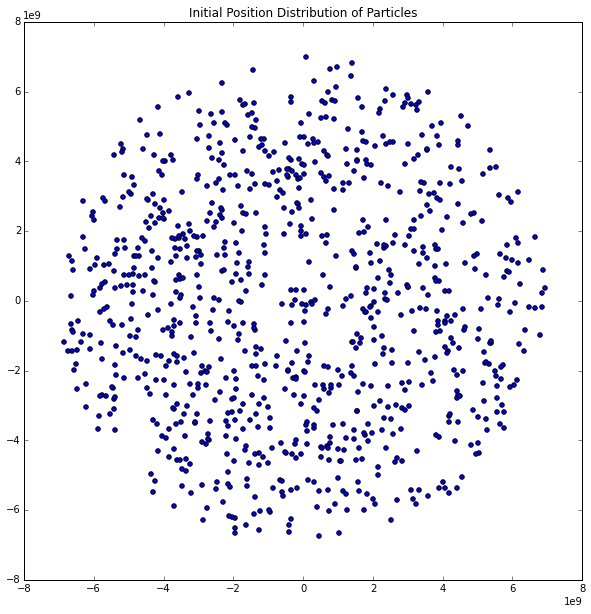

In [312]:
plt.figure(figsize=(10,10))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), radiusDistribution*np.sin(thetaDistribution))
plt.title("Initial Position Distribution of Particles")
plt.show()

### Model Initial Densities
* Currently modeling density as 4 distinct regions
    * Might want to follow up with the smoothing that comes with the density_j summation
* Modeling density as a continuous function of r now, using [equation 4.16]

In [313]:
rhoDistribution = rhoC * np.sin(radiusDistribution/alpha) / (radiusDistribution/alpha)

print radiusDistribution.shape, rhoDistribution.shape

(948L,) (948L,)


### Plot Initial Densities

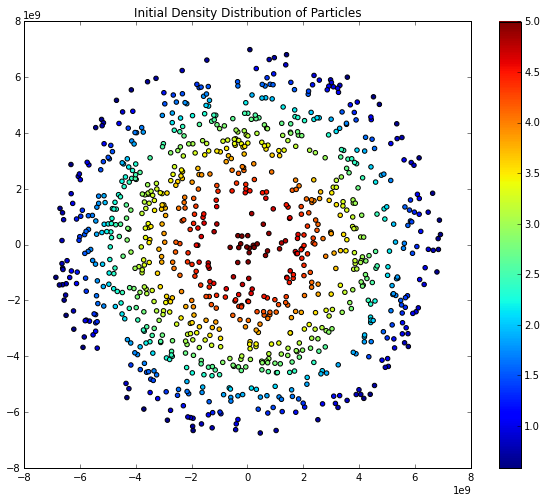

In [314]:
plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), radiusDistribution*np.sin(thetaDistribution), c=rhoDistribution)
plt.title("Initial Density Distribution of Particles")
plt.colorbar()
plt.show()

### Model Initial Pressure Distribution
* Currently modeling as simply polytropic
    * Might want to find P by solving the ODE [equation 4.14]

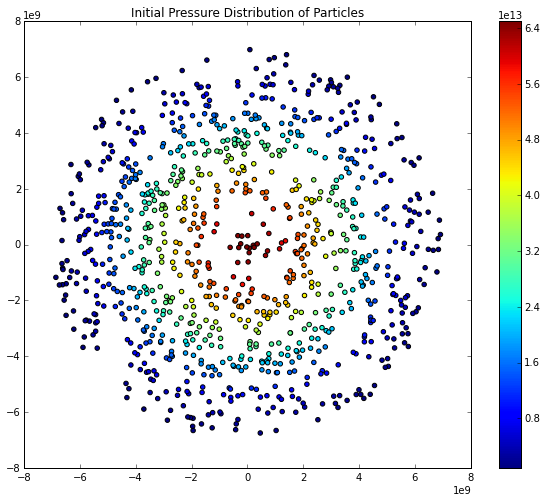

In [315]:
pressureDistribution = K * rhoDistribution ** gamma

plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=pressureDistribution)
plt.title("Initial Pressure Distribution of Particles")
plt.colorbar()
plt.show()

### Helper Function (Convert Polar Coordinates to Cartesian)

In [316]:
def polar2cart(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)]).T

xyDistribution = polar2cart(radiusDistribution, thetaDistribution)
nParticles = len(xyDistribution)

### Define Smoothing Function

\begin{equation}
W(r,h) = \frac{1}{\pi h^3} ( 1 - \frac{3}{2}(r/h)^2 + \frac{3}{4}(r/h)^3)
\end{equation}

\begin{equation}
W(r,h) = \frac{1}{4 \pi h^3} ( 2 - (r/h)^3)
\end{equation}

In [317]:
# MJupiter = 1.89e30    # grams

def W(xyDistribution, h= 3e9, verbose=False):
    '''
    h = ~3e9 looks like a good range
    Finding W for all pairs (i,j), instead of just j. 
    I'm flattening W at the end of the function. I might be meant to flatten W
        by flattening the |r-rj| by taking their sum
    '''
    
    distVect = np.zeros((len(xyDistribution), len(xyDistribution)))
                  
    # Find distance between each j and the other points
    for i in range(len(xyDistribution)):
        particle_i = xyDistribution[i]
        dist = np.sqrt((particle_i[0] - xyDistribution[:,0])**2 + (particle_i[1] - xyDistribution[:,1])**2)
        # Store distances in a matrix
        distVect[:,i] = dist
    
    # r < 1
    distVect1 = distVect < h
    distVect1 = distVect1.astype(int)
    if verbose:
        print "Percent of molecules within 1 smoothing length:", \
            np.count_nonzero(distVect1) / (len(xyDistribution)**2)
            
    # Matrix containing radii (where only nonzero values are radii < h)
    R1 = distVect1 * distVect   
    W1 = distVect1 / (np.pi * h**3) * (1 - 3/2*(R1/h)**2 + 3/4*(R1/h)**3)
    
    if np.min(W1) < 0:
        print "Warning! Negative smoothing kernel detected!"

    # r > 2h
    distVect2 = distVect > 2 * h
    distVect2 = distVect2.astype(int)
    if verbose:
        print "Percent of molecules which do not affect the particle:", \
            np.count_nonzero(distVect2) / (len(xyDistribution)**2)
    
    # h < r < 2h
    distVect12 = np.logical_not(np.logical_or(distVect1, distVect2))
    if verbose:
        print "Percent of molecules within 2 smoothing lengths:", \
                np.count_nonzero(distVect12) / (len(xyDistribution)**2)
            
    R12 = distVect12 * distVect 
    W12 = distVect12 / (4 * np.pi * h**3) * (2 - (R12/h))**3
    
    if np.min(W12) < 0:
        print "Warning! Negative smoothing kernel detected!"

    W = W1 + W12
    W = np.sum(W, axis=1)
    
    print np.count_nonzero(W)#, np.count_nonzero(distVect)
    return W

### Calculate Initial Mass Distribution
* Calculate using the smoothing equation [equation 4.4]
* Assume mass is fixed per particle afterwards
* The calculated mass distribution is on the same order of magnitude as Jupiter's true mass, which implies that the smoothing function doesn't have any bugs

948
The percent error of the calculated mass of Jupiter with respect to its true mass is 0.0144 %


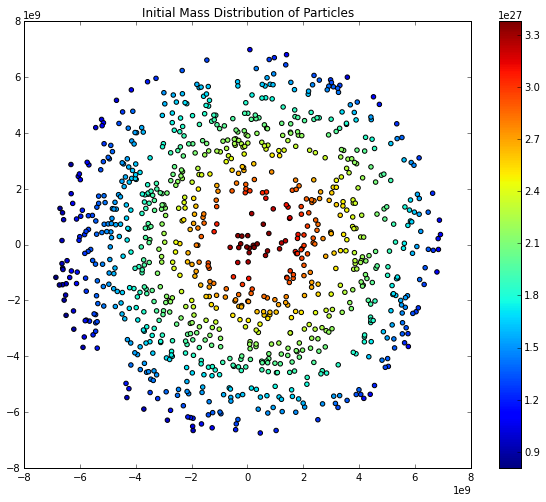

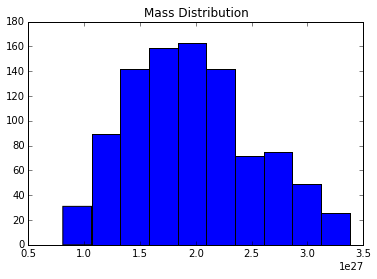

In [318]:
mDistribution = rhoDistribution/W(xyDistribution)
trueJupiterMass = 1.89e30    #g

massPercentError  = (trueJupiterMass- np.sum(mDistribution))/trueJupiterMass
print "The percent error of the calculated mass of Jupiter with respect to its true mass is", \
            "%.4f" % massPercentError, "%"

plt.figure(figsize=(10,8))
plt.scatter(radiusDistribution*np.cos(thetaDistribution), \
            radiusDistribution*np.sin(thetaDistribution), c=mDistribution)
plt.title("Initial Mass Distribution of Particles")
plt.colorbar()
plt.show()

plt.figure()
plt.hist(mDistribution)
plt.title("Mass Distribution")
plt.show()

### Model Initial Velocities

In [319]:
velocityDistribution = np.zeros_like(xyDistribution)

### Plot XYDistribution one more time

(-20000000000.0, 20000000000.0)

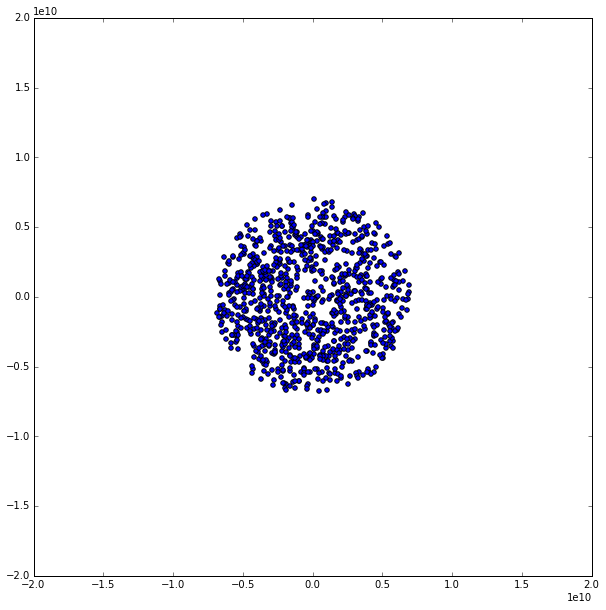

In [320]:
plt.figure(figsize=(10, 10))
plt.scatter(xyDistribution[:, 0], xyDistribution[:,1])
plt.xlim(-2e10, 2e10)
plt.ylim(-2e10, 2e10)

### Define Gradient of Smoothing Function

\begin{equation}
\nabla W(r,h) = \frac{1}{\pi h^3} \left( -3(r/h) + \frac{9}{4}(r/h)^2 \right)
\end{equation}

\begin{equation}
\nabla W(r,h) = -\frac{3}{4 \pi h^3} (r/h)^2
\end{equation}

\begin{equation}
\frac{d}{dx} W(x,h) = \frac{1}{4 \pi h^5} \left( -3xr \right)
\end{equation}

In [321]:
def gradW(h=1e9, verbose=False):
    
    # Initialize radial distance, x distance, and y distance
    distMatrix = cdist(xyDistribution, xyDistribution)
    X = np.zeros_like(distMatrix)
    Y = np.zeros_like(distMatrix)
    
    # Calculate distances between particle i and all other particles
    for i in range(nParticles):
        particle_i = xyDistribution[i]

        deltaX = particle_i[0] - xyDistribution[:,0]
        deltaY = particle_i[1] - xyDistribution[:,1]
        X[:,i] = deltaX
        Y[:,i] = deltaY

    # Look at particles within 1 smoothing length
    distMatrix1 = distMatrix < h
    R1 = distMatrix1 * distMatrix
    X1 = distMatrix1 * X
    Y1 = distMatrix1 * Y

    W1 = np.array(
                  [9*X1*R1/(4*h**3)-3*X1/(h**2),
                   9*Y1*R1/(4*h**3)-3*Y1/(h**2)]
                  ) * distMatrix1*10/(7*np.pi*h**2)
    W1 = np.sum(W1, axis=1)

    # Look at particles outside of 2 smoothing lengths
    distMatrix2 = distMatrix > 2*h
    
    # Look at particles h < r < 2h
    distMatrix12 = np.logical_not(np.logical_or(distMatrix1, distMatrix2))
    R12 = distMatrix12 * distMatrix
    X12 = distMatrix12 * X
    Y12 = distMatrix12 * Y
    
    # nan_to_num to take care of dividing by zero errors
    W12X = np.nan_to_num(-3*X12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2))
    W12Y = np.nan_to_num(-3*Y12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2))
    W12 = np.array([W12X, W12Y])
    W12 = np.sum(W12, axis=1)  
    
    ### --- Debugging --- ###
#     print "distMatrix1:\n", distMatrix1
#     print "distMatrix2:\n", distMatrix2
#     print "distMatrix12:\n", distMatrix12
#     print "distMatrix:\n", distMatrix
#     print "W1:\n", W1
#     print "X12:\n", X12
#     print "Num:\n", -3*X12*(2*h-R12)**2
#     print "Den:\n", (4*h**3*R12)
#     print "Num/Den:\n", -3*X12*(2*h-R12)**2/(4*h**3*R12)* distMatrix12*10/(7*np.pi*h**2)
#     print "W12X:\n", np.array([W12X, W12Y])
#     print "W12:\n", W12

    return np.array(W1+W12).T


print gradW()

[[ -2.45222989e-27   9.89706965e-28]
 [ -4.96804286e-28  -4.47219610e-28]
 [  1.66888292e-27   9.79753546e-29]
 ..., 
 [  1.04394066e-27  -3.56204593e-27]
 [ -5.40524724e-28   1.89844686e-27]
 [  1.44544542e-27   3.83862977e-27]]


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


### Define Pressure Gradient

In [322]:
def gradP():
    gradPX = mDistribution*pressureDistribution/rhoDistribution \
        * gradW()[:,0]
        
    gradPY = mDistribution*pressureDistribution/rhoDistribution \
        * gradW()[:,1]
    return np.array((gradPX, gradPY)).T

### Define Gravity

In [323]:
def gravity():
    
    global velocityDistribution
    global xyDistribution
    
    deltaV = np.zeros_like(xyDistribution, dtype = np.float)
    for j in range(0, nParticles):
        for k in range(0, nParticles):
            if (k!=j):
                xdist = (xyDistribution[j,0]-xyDistribution[k,0])
                ydist = (xyDistribution[j,1]-xyDistribution[k,1])
                #print(xdist)
                #print(ydist)

                if(xdist==0):
                    deltaV[j,0] += 0
                elif(xdist!=0):
                    deltaV[j,0] += -G*mDistribution[j]*xdist/((np.sqrt(xdist**2+ydist**2))**3)
                    #print("blah", -G*mDistribution[i]/(np.sqrt(abs(position[j,0]-position[i,0]))**2))
                    #print("v", i, "x", velocityDistribution[i,0])

                if(ydist==0):
                    deltaV[j,1] += 0
                elif(ydist!=0):
                    deltaV[j,1] += -G*mDistribution[j]*ydist/((np.sqrt(xdist**2+ydist**2))**3)
                    #print("v", i, "y", velocityDistribution[i,1])
    return deltaV

nb_gravity = nb.autojit(gravity)

print nb_gravity()
print gradP()

c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


[[ -3362.5472904    1002.69631815]
 [  9674.08535684 -35738.75990919]
 [   707.31574959   -256.85899933]
 ..., 
 [  1011.40483175  -3172.87798141]
 [  -508.71235481   1704.33341641]
 [  1893.66204885   2158.04559776]]
[[ -8.47815397e+13   3.42173793e+13]
 [ -2.17515963e+13  -1.95806290e+13]
 [  6.52370117e+13   3.82987881e+12]
 ..., 
 [  3.09110585e+12  -1.05472097e+13]
 [ -2.42097326e+12   8.50301360e+12]
 [  2.18399030e+12   5.79996317e+12]]


### Run Through RK1 (for gravity, not pressure)

In [302]:
# RK1 Parameters
t = 0
dt = 1e-1
stepN = 100

# Particle history
ParticlePositionHistory = np.zeros((nParticles,2,stepN))
ParticleVelocityHistory = np.zeros((nParticles,2,stepN))

for i in range(stepN):
    t += 1
    ParticlePositionHistory[:,:,i] = xyDistribution
#    deltaV = nb_gravity() * dt
    deltaV = -gradP()/rhoDistribution[:,np.newaxis] * dt
    velocityDistribution += deltaV
    deltaPos = velocityDistribution * dt
    xyDistribution += deltaPos
    
### --- Debugging --- ###
#    print "Mean velocity at timestep", t, "\n", np.mean(deltaV)
#    print "deltaV at timestep", t, "\n", deltaV
#    print "deltaPos at timestep", t, "\n", deltaPos
#    print "velocityDistribution at timestep", t, "\n", velocityDistribution

#     print "deltaPos:\n", deltaPos
#     print "xyDistribution:\n", xyDistribution

#     ParticleVelocityHistory[:,:,i] = -gradP()/rhoDistribution[:,np.newaxis] * dt


c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:39: RuntimeWarning: invalid value encountered in true_divide
c:\users\oromi_000\anaconda\lib\site-packages\ipykernel\__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


### Plot Position Change

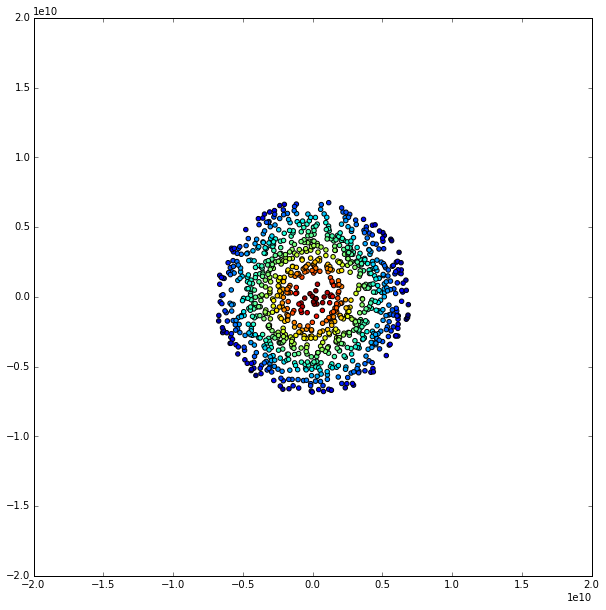

In [303]:
slider = FloatSlider(description='Time', min=0, max=stepN, step=1)

def update_plot():
    time=slider.value
    x = ParticlePositionHistory[:,0,time]
    y = ParticlePositionHistory[:,1,time]
    fig = plt.figure(figsize=(10,10))
    plt.scatter(x, y, c=mDistribution)
    plt.xlim(-2e10, 2e10)
    plt.ylim(-2e10, 2e10)

    clear_output(True)

slider.on_trait_change(update_plot, 'value')


display(slider)
update_plot()

### Model Initial Gravitational Force

#### Need to Run Entire Code to get reliable visuals! 

* Looking into https://www.wakari.io/sharing/bundle/yves/Continuum_N_Body_Simulation_Numba to do calcs
* Here has better approaches http://www.scholarpedia.org/article/N-body_simulations, but no code
* Ripping code from here: http://hilpisch.com/Continuum_N_Body_Simulation_Numba_27072013.html#/5/1

* The difference in position appears directly proportional to the size of time step

* A time step of e-21 allows the planet to stay relatively clumped up after 10000 RK1 steps
    * ie: Less than 10 particles were ejected into oblivion
    
\begin{equation}
\frac{d^2x}{dt^2} = -GM\frac{x}{r^3}
\end{equation}

\begin{equation}
\frac{d^2y}{dt^2} = -GM\frac{y}{r^3}
\end{equation}

Taken from Newman, page 386

In [304]:
# def gravity(position, velocity):
#     '''
#     Runs RK4 to update velocity and position. Takes numpy arrays as input.
#     '''
#     t0 = time.time(); nSteps = 100; dt = 1        
#     for step in range(1, nSteps + 1, 1):
#         for i in range(len(position)):
#             potentialX = 0.0; potentialY = 0.0
#             for j in range(len(position)):
#                 if j != i:
#                     deltaX = position[j,0] - position[i,0]
#                     deltaY = position[j,1] - position[i,1]
                    
#                     k1X = dt * -G * mDistribution[j] * deltaX / ((np.sqrt(deltaX**2 + deltaY**2))**3)
# #                    k2X = dt * -G * mDistribution[j] * (deltaX + 0.5*k1X)/ ((np.sqrt((deltaX + 0.5*k1X)**2 + deltaY**2))**3)
# #                    k3X = dt * -G * mDistribution[j] * (deltaX + 0.5*k2X)/ ((np.sqrt((deltaX + 0.5*k2X)**2 + deltaY**2))**3)
# #                    k4X = dt * -G * mDistribution[j] * (deltaX + k3X)/ ((np.sqrt((deltaX + k3X)**2 + deltaY**2))**3)
                    
#                     k1Y = dt * -G * mDistribution[j] * deltaY / ((np.sqrt(deltaX**2 + deltaY**2))**3)
# #                    k2Y = dt * -G * mDistribution[j] * (deltaY + 0.5*k1Y)/ ((np.sqrt((deltaY + 0.5*k1Y)**2 + deltaX**2))**3)
# #                    k3Y = dt * -G * mDistribution[j] * (deltaY + 0.5*k2Y)/ ((np.sqrt((deltaY + 0.5*k2Y)**2 + deltaX**2))**3)
# #                    k4Y = dt * -G * mDistribution[j] * (deltaY + k3Y)/ ((np.sqrt((deltaY + k3Y)**2 + deltaX**2))**3)

#                 velocity[i, 0] = k1X
#                 velocity[i, 1] = k1Y
# #                velocity[i, 0] += 1/6 * (k1X + 2*k2X + 2*k3X + k4X)
# #                velocity[i, 1] += 1/6 * (k1Y + 2*k2Y + 2*k3Y + k4Y)
#         for i in range(len(xyDistribution)):
#             position[i,0] += velocity[i,0] * dt
#             position[i,1] += velocity[i,1] * dt

In [305]:
# xyDistributionOld = np.copy(xyDistribution)

# nbody_nb = nb.autojit(gravity)
# firstrun = nbody_nb(xyDistribution, velocityDistribution)

In [306]:
# print xyDistribution - xyDistributionOld


# # [[-14817.86252546 -14254.34422445]
# #  [ 16439.8530407  -10828.22849607]
# #  [  -458.2766366   -6007.35716319]
# #  ..., 
# #  [-44791.12577057 -49775.21155739]
# #  [ -7136.9473145   57910.45627022]
# #  [ 10065.26782036  57367.43893051]]

In [307]:
# plt.figure(figsize=(10,10))
# plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
# plt.scatter(xyDistributionOld[:,0], xyDistributionOld[:,1], c='y')
# plt.xlim(-0.5e11, 0.5e11)
# plt.ylim(-0.5e11, 0.5e11)
# plt.title("Close-up of the Planet after 10K Time Steps")
# plt.plot()

In [308]:
# plt.figure(figsize=(10,10))
# plt.scatter(xyDistribution[:,0], xyDistribution[:,1], c='b')
# plt.scatter(xyDistributionOld[:,0], xyDistributionOld[:,1], c='y')
# plt.title("All the Particles of the Planet after 10K Time Steps")
# plt.plot()

### Calculate Pressure Gradient
